In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import yaml


# Prepare loss function

In [70]:
def obstacle_penalty(observation, penalty_factor):
    """
    Calculates the value of probability density function of a bivariate normal distribution at a given point.
    Arguments:
    x, y : float
        Coordinates of the point at which to calculate the probability density value.
    mu_x, mu_y : float
        Mean values (expectations) along the X and Y axes, respectively.
    sigma_x, sigma_y : float
        Standard deviations along the X and Y axes, respectively.
    rho : float
        Correlation coefficient between X and Y.

    Returns:
    float
        Value of the probability density function of a bivariate normal distribution at the given point (x, y).
    """
    mu_x = obstacle_x = -0.5
    sigma_x = obstacle_sigma = 0.2

    mu_y = obstacle_y = -0.5
    sigma_y = obstacle_sigma = 0.2
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

In [71]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(obstacle_penalty(observation=[X[i, j], Y[i, j]], penalty_factor=1e1))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
# len(Z)

In [72]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

# Get experiment information

## Load experiments

In [73]:
data_dir = "regelum_data/outputs"
experiment_dir = "regelum_data/mlruns"

chosen_exp_name = "calf_hyper_0108_1612"
chosen_exp_dir = None

def get_config_from_dir(dir_path):
    exp_config_path = os.path.join(dir_path, "meta.yaml")
    if not os.path.exists(exp_config_path):
        return {}

    with open(exp_config_path) as f:
        exp_config = yaml.safe_load(f)

    return exp_config

# 
for experiment in os.listdir(experiment_dir):
    experiment_path = os.path.join(experiment_dir, experiment)
    exp_config = get_config_from_dir(experiment_path)

    if exp_config.get("name") != chosen_exp_name:
        continue

    chosen_exp_dir = experiment_path

exp_list = []
for experiment in os.listdir(chosen_exp_dir):
    experiment_path = os.path.join(chosen_exp_dir, experiment)
    exp_config = get_config_from_dir(experiment_path)

    if not exp_config:
        continue

    exp_config["specific_data_path"] = exp_config["run_name"].replace(" ", "/")    
    exp_list.append(exp_config)

df = pd.DataFrame(exp_list)

def load_exp_config(sub_path):
    exp_dpath = os.path.join(data_dir, sub_path)
    os.listdir(exp_dpath)
    with open(os.path.join(exp_dpath, '.rehydra', 'config.yaml')) as f:
        exp_config = yaml.safe_load(f)
        
    return exp_config

def load_chosen_param(pdict, p):
    return pdict["policy"][p]

df["config"] = df["specific_data_path"].apply(load_exp_config)

for p in ["critic_desired_decay", "critic_low_kappa_coeff", "critic_up_kappa_coeff"]:
    df[p] = df["config"].apply(lambda x: load_chosen_param(x, p))

df.head()

,artifact_uri,end_time,entry_point_name,experiment_id,lifecycle_stage,run_id,run_name,run_uuid,source_name,source_type,source_version,start_time,status,tags,user_id,specific_data_path,config,critic_desired_decay,critic_low_kappa_coeff,critic_up_kappa_coeff
0,file:///regelum-playground/regelum_data/mlruns...,1722633773331,,379621631417894924,active,1221378442ae4170a11b4a62ebccc2f4,2024-08-02 21-33-18 6,1221378442ae4170a11b4a62ebccc2f4,,4,,1722627204405,3,[],root,2024-08-02/21-33-18/6,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000050,0.10,50.0
1,file:///regelum-playground/regelum_data/mlruns...,1722576302236,,379621631417894924,active,47cd45109a794798b68bf432626bbfe8,2024-08-02 05-38-49 3,47cd45109a794798b68bf432626bbfe8,,4,,1722569934214,3,[],root,2024-08-02/05-38-49/3,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000010,0.01,50.0
2,file:///regelum-playground/regelum_data/mlruns...,1722569412668,,379621631417894924,active,180922e5f6d94800b02bd7a5d4f907fa,2024-08-02 03-45-16 7,180922e5f6d94800b02bd7a5d4f907fa,,4,,1722563121083,3,[],root,2024-08-02/03-45-16/7,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000010,0.01,500.0
3,file:///regelum-playground/regelum_data/mlruns...,1722668972557,,379621631417894924,active,08fff5f237974e2e9ec089dd1cdd34a3,2024-08-03 07-08-43 0,08fff5f237974e2e9ec089dd1cdd34a3,,4,,1722661729019,3,[],root,2024-08-03/07-08-43/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000050,0.50,1000.0
4,file:///regelum-playground/regelum_data/mlruns...,1722782685837,,379621631417894924,active,f4e5c235f2814d199575f1ca507bc75c,2024-08-04 14-46-26 6,f4e5c235f2814d199575f1ca507bc75c,,4,,1722775592101,3,[],root,2024-08-04/14-46-26/6,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.10,1000.0


In [74]:
def get_df_from_folder(data_dir, exp_path):
    data_dir = os.path.join(data_dir, exp_path)
    df_list = []
    for root, dirs, files in os.walk(data_dir):
        if not root.endswith("HistoricalDataCallback"):
            continue

        for fn in files:
            if not fn.endswith(".h5"):
                continue

            file_path = os.path.join(root, fn)
            df = pd.read_hdf(file_path, key="data")
            df["exp_path"] = exp_path
            df["file_name"] = fn
            df["seed"] = os.path.basename(os.path.dirname(os.path.dirname(root)))
            df["dis_2_goal"] = df.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
            df_list.append(df)

    concat_df = pd.concat(df_list) if len(df_list) else pd.DataFrame()
    return concat_df

def add_columns_to_df(df):
    retrieved = {

    }
    for specific_data_path in df["specific_data_path"].unique():
        tmp_df = get_df_from_folder(data_dir, specific_data_path)
        retrieved[specific_data_path] = tmp_df.groupby("iteration_id").agg("max")["running_objective"].min()
        
    df["final_running_objective"] = df.apply(lambda row: retrieved[row["specific_data_path"]], axis=1)

    return df, tmp_df

def add_columns_to_df_2(df):
    retrieved = {}
    df_list = []
    for specific_data_path in df["specific_data_path"].unique():
        tmp_df = get_df_from_folder(data_dir, specific_data_path)
        test_df = df[df["specific_data_path"] == specific_data_path]

        for data in tmp_df.groupby("iteration_id").agg("max").iterrows():
            test_df["iteration"] = [data[0]]
            test_df["seed"] = [data[1]["seed"]]
            test_df["final_running_objective"] = [data[1]["running_objective"]]
            df_list.append(test_df.copy())
        
    concat_df = pd.concat(df_list, ignore_index=True) if len(df_list) else df

    return concat_df, tmp_df

# df, tmp_df = add_columns_to_df(df)
df, tmp_df = add_columns_to_df_2(df)

/tmp/ipykernel_1113627/3853059101.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["iteration"] = [data[0]]
/tmp/ipykernel_1113627/3853059101.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["seed"] = [data[1]["seed"]]
/tmp/ipykernel_1113627/3853059101.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [75]:
tmp_df.groupby("iteration_id").agg("max")

,time,running_objective,current_value,episode_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,exp_path,file_name,seed,dis_2_goal
iteration_id,,,,,,,,,,,,,,,,,,,
1,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,0.655639,-1180.476933,1.186960,1186.960440,1181.132572,2024-08-03/17-12-59/9,observations_actions_it_00001.h5,9,1.414214
2,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,0.718292,-1085.500533,1.186960,1186.960440,1086.218824,2024-08-03/17-12-59/9,observations_actions_it_00002.h5,9,1.414214
3,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,0.710869,-969.966459,1.186960,1186.960440,970.677328,2024-08-03/17-12-59/9,observations_actions_it_00003.h5,9,1.414214
4,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,0.699986,-763.706623,1.186960,1186.960440,764.406609,2024-08-03/17-12-59/9,observations_actions_it_00004.h5,9,1.414214
5,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,99.710292,-628.497392,1.186960,1186.960440,728.207684,2024-08-03/17-12-59/9,observations_actions_it_00005.h5,9,1.414214
6,9.0,108.814458,40.031684,1,0.22,2.840000,-0.006806,-0.004814,3.141593,1,38.985672,38.986541,1.186960,1186.960440,0.038684,2024-08-03/17-12-59/9,observations_actions_it_00006.h5,9,1.414214
7,11.9,183.209770,39.634398,1,0.22,2.840000,-0.007684,-0.003573,3.251476,1,1155.427387,3187.646037,1.257469,1257.469470,0.056353,2024-08-03/17-12-59/9,observations_actions_it_00007.h5,9,1.430472
8,10.2,141.961837,37.164679,1,0.22,2.840000,-0.008785,-0.003050,3.141593,1,178.048175,178.048186,1.186960,1186.960440,0.040066,2024-08-03/17-12-59/9,observations_actions_it_00008.h5,9,1.427475
9,7.4,95.073674,39.549771,1,0.22,0.095238,-0.008980,-0.004318,3.141593,0,1.186733,-1469.282258,1.186960,1186.960440,1470.468991,2024-08-03/17-12-59/9,observations_actions_it_00009.h5,9,1.414214


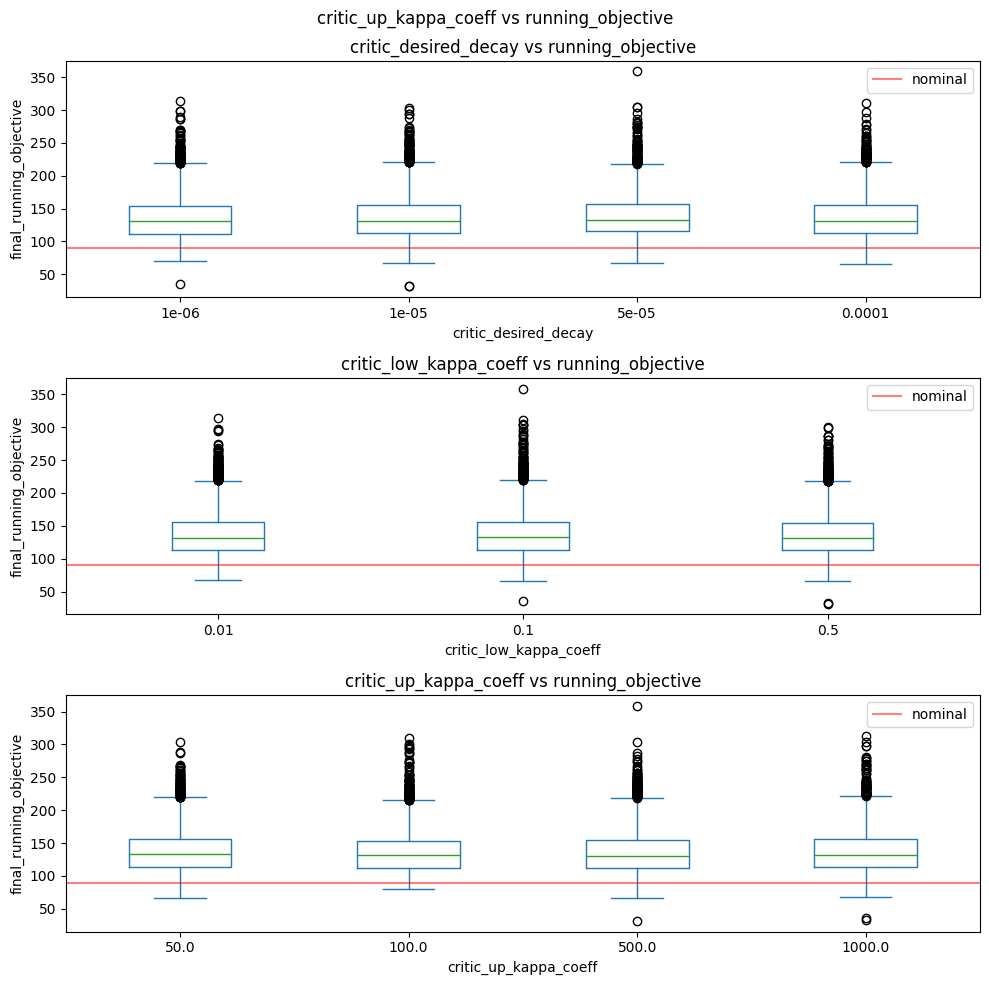

In [76]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
df.plot.box(by="critic_desired_decay", column="final_running_objective", ax=ax[0])
ax[0].set_title("critic_desired_decay vs running_objective")
ax[0].set_xlabel("critic_desired_decay")
ax[0].set_ylabel("final_running_objective")

df.plot.box(by="critic_low_kappa_coeff", column="final_running_objective", ax=ax[1])
ax[1].set_title("critic_low_kappa_coeff vs running_objective")
ax[1].set_xlabel("critic_low_kappa_coeff")
ax[1].set_ylabel("final_running_objective")

df.plot.box(by="critic_up_kappa_coeff", column="final_running_objective", ax=ax[2], title="critic_up_kappa_coeff vs running_objective")
ax[2].set_title("critic_up_kappa_coeff vs running_objective")
ax[2].set_xlabel("critic_up_kappa_coeff")
ax[2].set_ylabel("final_running_objective")

for ax_i in ax:
    ax_i.axhline(y=90, color='r', linestyle='-', label="nominal", alpha=0.5)
    ax_i.legend()

plt.tight_layout()

In [77]:
df.final_running_objective.min()

31.77269504826661

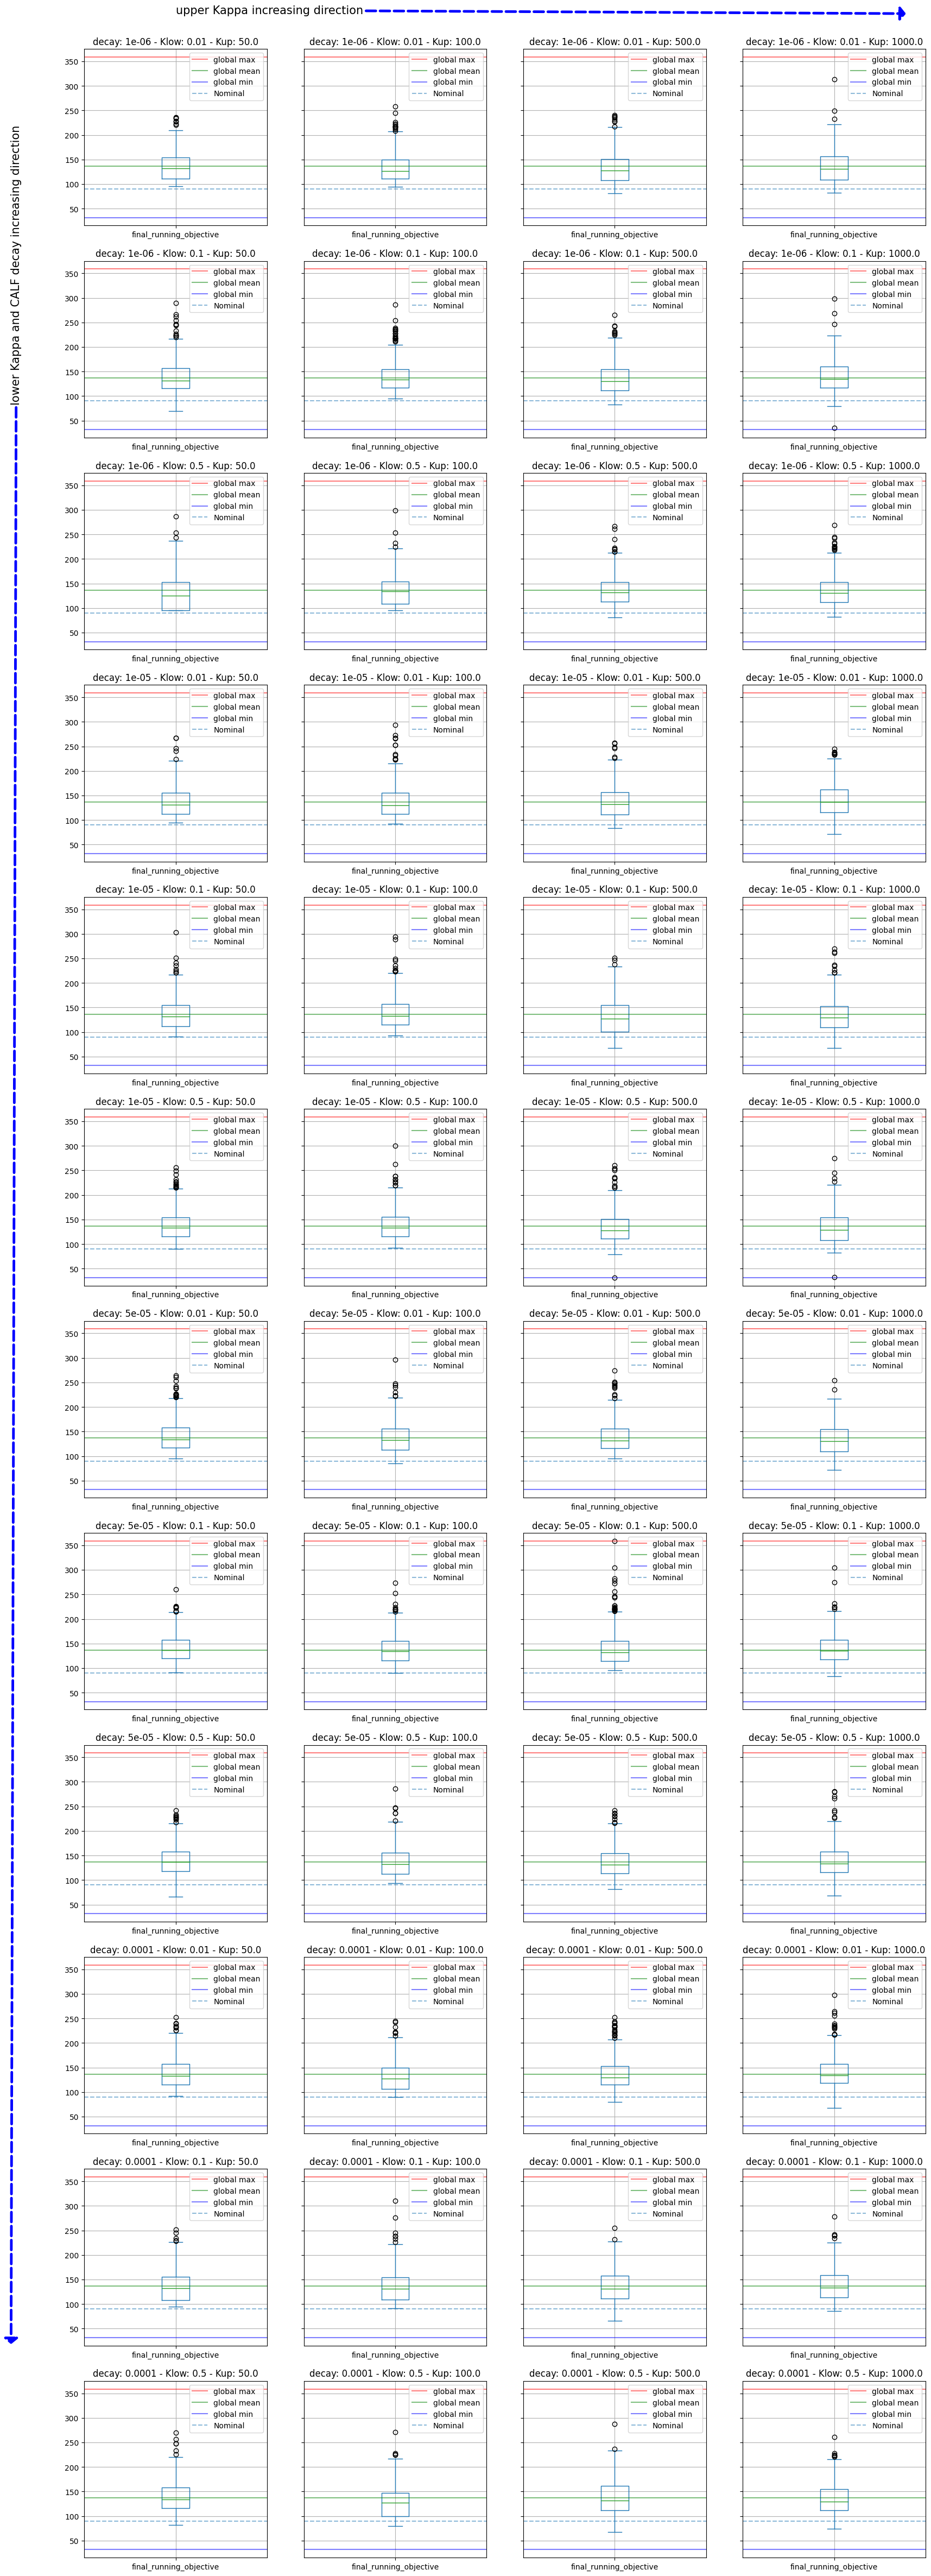

In [78]:
group_df = df.groupby(["critic_desired_decay", "critic_low_kappa_coeff", "critic_up_kappa_coeff"])
# group_df.plot.box(column="final_running_objective", title="critic_up_kappa_coeff vs running_objective")

obj_min = group_df["final_running_objective"].min().min()
obj_avg = group_df["final_running_objective"].mean().mean()
obj_max = group_df["final_running_objective"].max().max()

ncols=4
nrows = int(np.ceil(group_df.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols,5*nrows), sharey=True)

draw_annotation = True

for (key, ax) in zip(group_df.groups.keys(), axes.flatten()):
    group_df.get_group(key)["final_running_objective"].plot.box(ax=ax)
    ax.set_title("decay: {} - Klow: {} - Kup: {}".format(*key))
    ax.axhline(y=obj_max, color='r', linestyle='-', alpha=0.5, label="global max")
    ax.axhline(y=obj_avg, color='g', linestyle='-', alpha=0.5, label="global mean")
    ax.axhline(y=obj_min, color='b', linestyle='-', alpha=0.5, label="global min")
    ax.axhline(y=90, color='tab:blue', linestyle='--', alpha=0.5, label="Nominal")

    if draw_annotation:
        trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction

        ann = ax.annotate('upper Kappa increasing direction', 
                          xy=(5, 1.2),
                          xycoords=trans,
                          xytext=(1, 1.2),
                          textcoords=trans,
                          arrowprops=dict(arrowstyle= '-|>, head_width=0.5',
                                          color='blue',
                                          lw=3.5,
                                          ls='--'),
                          annotation_clip=False
           )
        ann.set_size(15)

        ann = ax.annotate('lower Kappa and CALF decay increasing direction', 
                          xy=(0.1, -12),
                          xycoords=trans,
                          xytext=(0.1, -1),
                          textcoords=trans,
                          arrowprops=dict(arrowstyle= '-|>, head_width=0.5',
                                          color='blue',
                                          lw=3.5,
                                          ls='--'),
                          annotation_clip=False,
                          rotation=90
           )
        ann.set_size(15)

        draw_annotation = False

    ax.grid()
    ax.legend()

fig.savefig("media/hyperparameter_matrix.svg")
plt.show()


In [79]:
group_df["final_running_objective"].min().min()

31.77269504826661

In [80]:
group_df.groups[(1e-06, 0.01, 50.0)]

Index([  680,   681,   682,   683,   684,   685,   686,   687,   688,   689,
       ...
       17510, 17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519],
      dtype='int64', length=400)

In [81]:
group_df.get_group((1e-06, 0.01, 50.0))

,artifact_uri,end_time,entry_point_name,experiment_id,lifecycle_stage,run_id,run_name,run_uuid,source_name,source_type,...,tags,user_id,specific_data_path,config,critic_desired_decay,critic_low_kappa_coeff,critic_up_kappa_coeff,iteration,seed,final_running_objective
680,file:///regelum-playground/regelum_data/mlruns...,1722831363276,,379621631417894924,active,b82d311af9f842e3852340f5f6a45743,2024-08-05 04-32-31 0,b82d311af9f842e3852340f5f6a45743,,4,...,[],root,2024-08-05/04-32-31/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,1,0,121.124869
681,file:///regelum-playground/regelum_data/mlruns...,1722831363276,,379621631417894924,active,b82d311af9f842e3852340f5f6a45743,2024-08-05 04-32-31 0,b82d311af9f842e3852340f5f6a45743,,4,...,[],root,2024-08-05/04-32-31/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,2,0,128.668355
682,file:///regelum-playground/regelum_data/mlruns...,1722831363276,,379621631417894924,active,b82d311af9f842e3852340f5f6a45743,2024-08-05 04-32-31 0,b82d311af9f842e3852340f5f6a45743,,4,...,[],root,2024-08-05/04-32-31/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,3,0,113.438740
683,file:///regelum-playground/regelum_data/mlruns...,1722831363276,,379621631417894924,active,b82d311af9f842e3852340f5f6a45743,2024-08-05 04-32-31 0,b82d311af9f842e3852340f5f6a45743,,4,...,[],root,2024-08-05/04-32-31/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,4,0,138.576510
684,file:///regelum-playground/regelum_data/mlruns...,1722831363276,,379621631417894924,active,b82d311af9f842e3852340f5f6a45743,2024-08-05 04-32-31 0,b82d311af9f842e3852340f5f6a45743,,4,...,[],root,2024-08-05/04-32-31/0,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,5,0,118.278981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,file:///regelum-playground/regelum_data/mlruns...,1722831845271,,379621631417894924,active,601e204a3082450181bb7c2b790d5f25,2024-08-05 04-32-31 7,601e204a3082450181bb7c2b790d5f25,,4,...,[],root,2024-08-05/04-32-31/7,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,36,7,169.885148
17516,file:///regelum-playground/regelum_data/mlruns...,1722831845271,,379621631417894924,active,601e204a3082450181bb7c2b790d5f25,2024-08-05 04-32-31 7,601e204a3082450181bb7c2b790d5f25,,4,...,[],root,2024-08-05/04-32-31/7,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,37,7,144.157374
17517,file:///regelum-playground/regelum_data/mlruns...,1722831845271,,379621631417894924,active,601e204a3082450181bb7c2b790d5f25,2024-08-05 04-32-31 7,601e204a3082450181bb7c2b790d5f25,,4,...,[],root,2024-08-05/04-32-31/7,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,38,7,118.986801
17518,file:///regelum-playground/regelum_data/mlruns...,1722831845271,,379621631417894924,active,601e204a3082450181bb7c2b790d5f25,2024-08-05 04-32-31 7,601e204a3082450181bb7c2b790d5f25,,4,...,[],root,2024-08-05/04-32-31/7,{'policy': {'_target_': 'src.policy.ThreeWheel...,0.000001,0.01,50.0,39,7,182.770865
